In [249]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import pandas_profiling as pp
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


In [154]:
df = pd.read_csv('bank/bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [295]:
pp.ProfileReport(df)

Number of variables,18
Number of observations,45211
Total Missing (%),0.0%
Total size in memory,6.2 MiB
Average record size in memory,144.0 B
Numeric,7
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [156]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [157]:
df.pdays.describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [158]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

## Questões

### Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

In [159]:
pd.concat([df.job.value_counts(), df.job.value_counts()/df.shape[0]], axis=1)

,job,job
blue-collar,9732,0.215257
management,9458,0.209197
technician,7597,0.168034
admin.,5171,0.114375
services,4154,0.091880
retired,2264,0.050076
self-employed,1579,0.034925
entrepreneur,1487,0.032890
unemployed,1303,0.028820
housemaid,1240,0.027427


In [160]:
count_housing_loan = df[(df.housing == 'yes') | (df.loan=='yes')]['job'].value_counts()
count_housing_loan.head()

blue-collar    7599
management     5225
technician     4608
admin.         3569
services       3063
Name: job, dtype: int64

In [161]:
pd.concat([count_housing_loan, count_housing_loan/count_housing_loan.sum()], axis=1).head()

,job,job
blue-collar,7599,0.271325
management,5225,0.186561
technician,4608,0.164530
admin.,3569,0.127432
services,3063,0.109366


Uma verificação nas variáveis __housing__ e __loan__, as que indicam a aquisição de empréstimo ou não, indicam que a profissão que mais adquire empréstimo é a classe __blue_collar__ (27%). Em seguida aparecem __gerentes__ (18%) e __técnicos__ (16%).

In [162]:
count_housing = df[df.housing=='yes']['job'].value_counts()
count_housing.head()

blue-collar    7048
management     4678
technician     4115
admin.         3182
services       2766
Name: job, dtype: int64

In [163]:
pd.concat([count_housing, count_housing/count_housing.sum()], axis=1).head()

,job,job
blue-collar,7048,0.280462
management,4678,0.186152
technician,4115,0.163749
admin.,3182,0.126622
services,2766,0.110068


In [164]:
count_loan = df[df.loan=='yes']['job'].value_counts()
count_loan.head()

blue-collar    1684
technician     1309
management     1253
admin.          991
services        836
Name: job, dtype: int64

In [165]:
pd.concat([count_loan, count_loan/count_loan.sum()], axis=1).head()

,job,job
blue-collar,1684,0.232468
technician,1309,0.180701
management,1253,0.172971
admin.,991,0.136803
services,836,0.115406


In [166]:
hausing = df[(df.housing=='yes') & (df.job=='blue-collar')].index
loan = df[(df.loan=='yes') & (df.job=='blue-collar')].index
hausing.size, loan.size, hausing.intersection(loan).size, hausing.union(loan).size 

(7048, 1684, 1133, 7599)

In [167]:
5915/7599,  1133/7599, 551/7599

(0.7783918936702198, 0.14909856560073695, 0.0725095407290433)

Analisando as duas variáveis separadamente na classe de trabalhadores __blue_collar__, fica evidente que a maioria dos empréstimos adquiridos são os relacionados à aquisição de habitações. Dos 7599 trabalhados da classe que possuem algum tipo de empréstimo, 78% e 7% são do tipo habitação e pessoal, respectivamente. Vale observar que 1133 (em torno de 15%) possuem empréstimos dos dois tipos. O diagrama abaixo ajuda na visualização desses números.

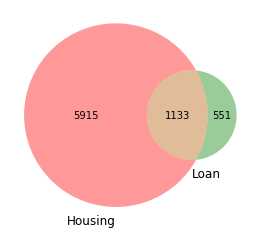

In [168]:
from matplotlib_venn import venn2
venn2([set(hausing), set(loan)], set_labels = ('Housing', 'Loan'), )
plt.show()

### Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados? 

In [169]:
count_campaign_sucesso = pd.DataFrame(df.groupby(by=['campaign', 'y'])['age'].count()).reset_index()
count_campaign_sucesso.columns = ['numero_ligacoes', 'sucesso', 'volume']
count_campaign_sucesso['sucesso_encoded'] = count_campaign_sucesso.sucesso.apply(lambda x: 1 if x == 'yes' else 0)
count_campaign_sucesso.head()

,numero_ligacoes,sucesso,volume,sucesso_encoded
0,1,no,14983,0
1,1,yes,2561,1
2,2,no,11104,0
3,2,yes,1401,1
4,3,no,4903,0


In [170]:
count_campaign_sucesso[(count_campaign_sucesso.numero_ligacoes>30) & (count_campaign_sucesso.sucesso == 'no')].shape[0]/ count_campaign_sucesso[(count_campaign_sucesso.numero_ligacoes>30)].shape[0],


(0.9473684210526315,)

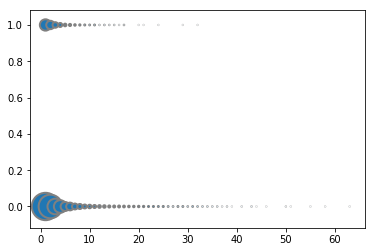

In [171]:
plt.scatter(count_campaign_sucesso.numero_ligacoes, count_campaign_sucesso.sucesso_encoded, s=count_campaign_sucesso.volume*0.05,  edgecolors="grey", linewidth=2)

O ponto mais relevante observado na associação do __número de contatos__ e o __sucesso da campanha__ é o fato de que o número de que aumentar o número de ligações não aumenta a aderência à campanha. Como pode ser visto no gráfico anterior, quando foram realizadas mais de 30 ligações, a maioria dos clientes não foram positivados (aproximadamente 95%). Pelo gráfico ainda é possível observar que a maioria dos clientes positivados o foram com menos que 4 ligações.

### Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão? 

In [172]:
pd.concat([df.y.value_counts(), df.y.value_counts()/df.shape[0]], axis=1)

,y,y
no,39922,0.883015
yes,5289,0.116985


In [173]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [174]:
df[df.y =='yes']['campaign'].describe()

count    5289.000000
mean        2.141047
std         1.921826
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        32.000000
Name: campaign, dtype: float64

In [175]:
df[df.y =='no']['campaign'].describe()

count    39922.000000
mean         2.846350
std          3.212767
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [176]:
df.campaign.mean(), df.campaign.median(), df.campaign.mode()

(2.763840658246887, 2.0, 0    1
 dtype: int64)

In [177]:
df[df.y=='yes']['campaign'].mean(),df[df.y=='yes']['campaign'].median(), df[df.y=='yes']['campaign'].mode()

(2.1410474569861977, 2.0, 0    1
 dtype: int64)

In [178]:
df[df.y=='no']['campaign'].mean(),df[df.y=='no']['campaign'].median(), df[df.y=='no']['campaign'].mode()

(2.8463503832473322, 2.0, 0    1
 dtype: int64)

Duas das medidas de centralidade, média e mediana, sugerem 2 ligações na média para otimizar a adesão da campanha. No próximo gráfico, conseguimos observar que a distribuição das ligações não é exatamente normal, então para não correr o risco de escolher um que não reflete a realidade, descartamos a média aritmética, e usamos a mediana, que coincidentemente está muito próxima da média. Consiserando também os custos envolvidos, acredito que duas ligações por cliente, na média, é suficiente para se obter uma adesão próxima da ótima. No máximo, recomendaria 4 ligações por cliente (mediana + 1 desvio padrão no caso em que os clientes aderiram à campanha).

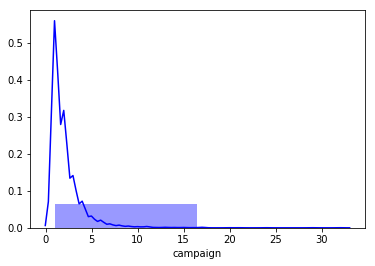

In [179]:
sns.distplot(df[df.y == 'yes']['campaign'] , color="b", label="yes", bins=2)

####  O resultado da campanha anterior tem relevância na campanha atual?

In [180]:
533+978+4283+618

6412

Usaremos um teste estatístico não paramético para duas variáveis pareadas. Para isso, consideraremos apenas os registros em que o valor da variável __poutcome__ fossem _failure_ ou _success_, já que são nesses casos que temos informações mais precisas. Assim, o teste foi aplicado em um total de __6412__ registros da base total.

A hipótese que estamos testando:

    h0: o resultado da campanha anterior não influência a campanha atual.

    h1: o resultado da campanha anterior influência a campanha atual.
    
    
O teste de McNemar para significância de mudanças é escolhido porque o estudo usa duas amostras relacionadas, do tipo “antes
e depois” e usa medidas categóricas. Para a aplicação do teste, é necessário uma tabela de quatro partes que descreva as mudanças dos resultados de ambas as campanhas. 

In [181]:
# Antes           Depois
#           _____________________  
#           failure      success  
# success   A=533       B=978
# failure   C=4283      D=618

Com a tabela anterior, calculamos o valor de _x2c_ (qui-quadrado), usando a equação _x2c_ = (|A-D|-1)**2 /(A+D)

In [182]:
d = {'antes': ['sucesso', 'insucesso'], 'depois_insucesso': [533, 4283],'depois_sucesso': [978,618] }
outcome = pd.DataFrame(data=d)
outcome

,antes,depois_insucesso,depois_sucesso
0,sucesso,533,978
1,insucesso,4283,618


In [183]:
x2c = (np.absolute(outcome.iloc[0,1] - outcome.iloc[1,2]) - 1)**2 /(outcome.iloc[0,1] + outcome.iloc[1,2])
x2c

6.1303214596003475

O _x2c_ calculado é 6.130, e é distribuído assintoticamente como um qui-quadrado com 1 grau de liberdade (gl=1). O valor crítico tabelado para o qui-quadrado com gl=1 e nível de significância 0.05 é 3.84 (https://www.ime.unicamp.br/~cnaber/Tabela%20da%20Qui-quadrado.pdf ). Como o valor observado (6.130) é maior que o valor crítico do qui_quadrado (3.84) rejeitamos a hipóstese nula, ou seja, o resultado da campanha anterior tem relevância para a campanha atual.

Para a análise das duas próximas questões, serão consideradas as variáveis que dizem respeito aos indíviduos, e não as relacionadas às campanhas de marketing.

### Qual o fator determinante para que o banco exija um seguro de crédito?

Entendo que um seguro de crédito é exigido por um banco quando o risco de o cliente não pagar seus empréstimos é alto. Nesta questão, assumirei que possui crédito aqueles indivíduos que possuem pelo menos um dos créditos __housing__ ou __loan__.

In [271]:
df.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

In [272]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [273]:
df['has_credit'] = df.apply(lambda x: 'yes' if (x['loan'] == 'yes') | (x['housing']=='yes') else  'no', axis=1)
df.has_credit.value_counts()

yes    28007
no     17204
Name: has_credit, dtype: int64

As variáveis que dizem respeito aos indíviduo são _'age', 'job', 'marital', 'default', 'education', 'balance'_. A seguir são realizados alguns pré processamentos para deixar os dados adequados para condução da análise.

In [274]:
df2 = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'has_credit']]

In [275]:
df2.age.describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

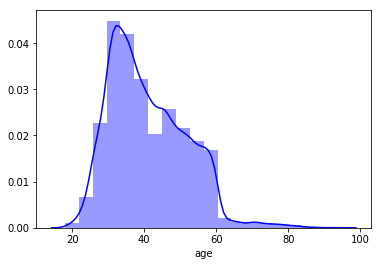

In [276]:
sns.distplot(df2.age , color="b", label="yes", bins=20)

Como pode ser observado no histograma acima, a variável __age__ possui alguns valores bem acima da média. Removeremos os indíviduos cuja idade esteja a 1 interquantil acima da média, já que a distribuição possui uma calda longa à direita.

In [277]:
from scipy.stats import iqr
irq = iqr(df2.age)
irq

15.0

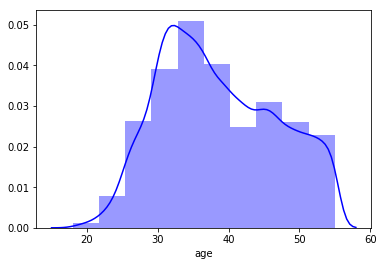

In [278]:
df2 = df2[df2.age <= df2.age.mean()+irq]
sns.distplot(df2.age, color="b", label="yes", bins=10)

A presença de outliers também é observado na variável __balance__. Usando o mesmo raciocínio, mas dos dois lados da distribuição.

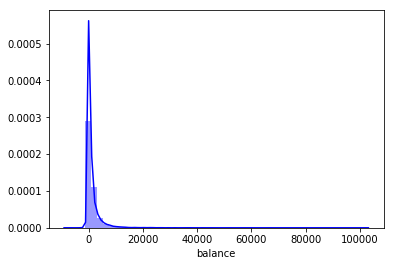

In [279]:
sns.distplot(df2.balance , color="b", label="yes", bins=50)

In [280]:
irq = iqr(df2.balance)
irq

1274.0

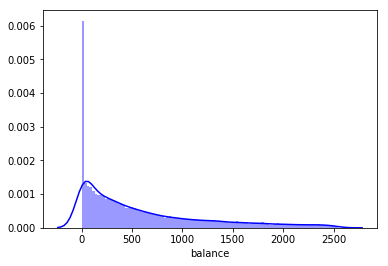

In [281]:
df2 = df2[(df2.balance <= df2.balance.mean()+irq) & (df2.balance >= df2.balance.mean()-irq) ]
sns.distplot(df2.balance, color="b", label="yes", bins=100)

In [282]:
df2.shape

(31151, 7)

In [283]:
df2.balance.describe()

count    31151.000000
mean       595.601265
std        626.259144
min          0.000000
25%         99.000000
50%        375.000000
75%        900.000000
max       2547.000000
Name: balance, dtype: float64

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


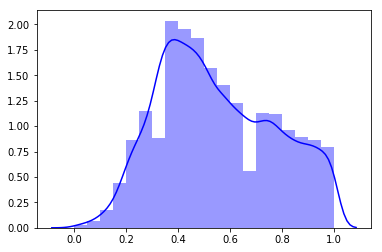

In [284]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
sns.distplot(scaler.fit_transform(df2.age.values.reshape(-1, 1)) , color="b", label="yes", bins=20)

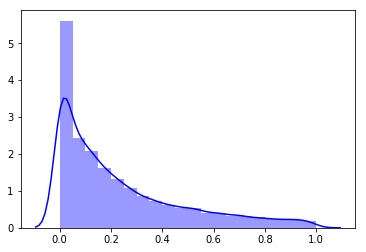

In [285]:
sns.distplot(scaler.fit_transform(df2.balance.values.reshape(-1, 1)) , color="b", label="yes", bins=20)

Transformando as variáveis _'job', 'marital', 'education', 'default'_ em números, para poderem serem utilizadas no algoritmo.

In [286]:
df2.default = df2.default.apply(lambda x: 1 if x == 'yes' else 0)
le = LabelEncoder()
df2.job = le.fit_transform(df2.job)
print(le.classes_)
df2.marital = le.fit_transform(df2.marital)
print(le.classes_)
df2.education = le.fit_transform(df2.education)
print(le.classes_)
df2.head()

['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
['divorced' 'married' 'single']
['primary' 'secondary' 'tertiary' 'unknown']


,age,job,marital,education,default,balance,has_credit
1,44,9,2,1,0,29,yes
2,33,2,1,1,0,2,yes
3,47,1,1,3,0,1506,yes
4,33,11,2,3,0,1,no
5,35,4,1,2,0,231,yes


In [287]:
df2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance',
       'has_credit'],
      dtype='object')

Por fim, escalamos os dados, para que todas as variáveis estejam na mesma escala de magnitude.

In [288]:
scaler = StandardScaler()
X = scaler.fit_transform(df2[['age', 'job', 'marital', 'education', 'balance']], y=df2.has_credit)
X

array([[ 0.68405389,  1.39083756,  1.28251861, -0.32948634, -0.90475383],
       [-0.64589737, -0.69337335, -0.34279107, -0.32948634, -0.94786767],
       [ 1.04676786, -0.99111776, -0.34279107,  2.42627388,  1.45373262],
       ...,
       [-1.85494396,  1.09309314,  1.28251861,  1.04839377, -0.7706219 ],
       [-1.61313464,  1.39083756,  1.28251861, -0.32948634, -0.14467289],
       [ 1.5303865 ,  1.39083756, -0.34279107,  1.04839377,  0.3663059 ]])

In [289]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.cluster_centers_

array([[ 0.61724028, -0.24551831, -0.61102786, -0.32513576,  0.0337994 ],
       [-0.69236685,  0.27540124,  0.6853983 ,  0.36470922, -0.03791325]])

In [290]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[ 43.447386  ,   3.50415933,   0.83496266,   1.00315745,
        616.76810978],
       [ 32.61565182,   5.25371203,   1.63261136,   1.50381419,
        571.8581256 ]])

In [294]:
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 0], dtype=int32)

In [293]:
pd.value_counts(kmeans.labels_)

0    16476
1    14675
dtype: int64

In [292]:
"""
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
sns.distplot(scaler.fit_transform(df2.age.values.reshape(-1, 1)) , color="b", label="yes", bins=20)
df.balance.describe()
sns.distplot(df.balance , color="b", label="yes", bins=100)
df2 = df[['age', 'job', 'marital', 'education', 'balance', 'has_credit']]
df2['has_credit_bin'] = df2.has_credit.apply(lambda x: 1 if x == 'yes' else 0)
df2.head()
sns.distplot(df2.balance , color="b", label="yes", bins=200)
le = preprocessing.LabelEncoder()
df2.job = le.fit_transform(df2.job)
df2.marital = le.fit_transform(df2.marital)
df2.education = le.fit_transform(df2.education)
df2.head()
kmeans = KMeans(n_clusters=2, random_state=0).fit(df2[[ 'balance', 'has_credit_bin']])
kmeans.cluster_centers_
"""

'\nfrom sklearn.preprocessing import MinMaxScaler, StandardScaler\nscaler = StandardScaler()\nsns.distplot(scaler.fit_transform(df2.age.values.reshape(-1, 1)) , color="b", label="yes", bins=20)\ndf.balance.describe()\nsns.distplot(df.balance , color="b", label="yes", bins=100)\ndf2 = df[[\'age\', \'job\', \'marital\', \'education\', \'balance\', \'has_credit\']]\ndf2[\'has_credit_bin\'] = df2.has_credit.apply(lambda x: 1 if x == \'yes\' else 0)\ndf2.head()\nsns.distplot(df2.balance , color="b", label="yes", bins=200)\nle = preprocessing.LabelEncoder()\ndf2.job = le.fit_transform(df2.job)\ndf2.marital = le.fit_transform(df2.marital)\ndf2.education = le.fit_transform(df2.education)\ndf2.head()\nkmeans = KMeans(n_clusters=2, random_state=0).fit(df2[[ \'balance\', \'has_credit_bin\']])\nkmeans.cluster_centers_\n'

### Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário? 